## Appendix

Additional exploration was conducted for the [CDC's 500 cities Project](https://chronicdata.cdc.gov/500-Cities/500-Cities-Census-Tract-level-Data-GIS-Friendly-Fo/k86t-wghb) to understand the severity of various health conditions and diseases across the country. The health data from this dataset can be incorporated into the priority score functions, allowing cities with higher disease prevalence, such as diabetes and obesity, could be given higher priority. Increasing access to fruits and vegetables could potentially help reduce these rates. 

In [1]:
import pandas as pd
import sqlite3

import plotly.express as px
from urllib.request import urlopen
import json

from IPython.display import Image, display
import plotly.io as pio


### Importing the database

The dataset was loaded in using `sqlite3`, and then cleaned up to ensure no `NaN` or duplicate rows. The features of interest, specifically the crude prevalance of diabetes, obesity, high cholesterol, and high blood pressure, were selected due to their known association to diets. 

In [2]:
database_path = './challenge.db'

connection = sqlite3.connect(database_path)

df_access = pd.read_sql_query('SELECT * FROM access', connection)
df_five_hundred_cities =  pd.read_sql_query('SELECT * FROM five_hundred_cities', connection)
connection.close()

df_five_hundred_cities.head()

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,...,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,...,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,...,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"
3,3,AL,Birmingham,107000,1073000500,0107000-01073000500,2864,25.2,"(21.6, 29.0)",35.0,...,"(82.1, 86.5)",21.7,"(19.7, 23.9)",46.1,"(44.5, 47.4)",7.3,"( 6.5, 8.2)",34.0,"(24.4, 42.9)","(33.54424045940, -86.7749130719)"
4,4,AL,Birmingham,107000,1073000700,0107000-01073000700,2577,29.0,"(24.5, 33.8)",36.3,...,"(82.2, 87.1)",25.5,"(23.1, 28.0)",48.3,"(46.6, 49.7)",9.0,"( 8.1, 10.0)",43.2,"(33.2, 53.2)","(33.55254061390, -86.8016893706)"


In [3]:
df_five_hundred_cities.describe()

,index,PlaceFIPS,TractFIPS,Population2010,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,...,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PAPTEST_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
count,27210.000000,2.721000e+04,2.721000e+04,27210.000000,27209.000000,27210.000000,27210.000000,27210.000000,27210.000000,27210.000000,...,27210.000000,27210.000000,27173.000000,27210.000000,27210.000000,25008.000000,27210.000000,27210.000000,27210.000000,27150.000000
mean,13604.500000,2.605539e+06,2.586284e+10,3785.703087,16.990915,21.430129,18.066953,30.653208,70.744274,5.648912,...,3.099666,27.593671,79.190976,13.921040,30.472922,83.085749,12.882962,36.716836,3.211466,16.108107
std,7854.994749,1.681206e+06,1.671749e+10,1944.825182,8.869361,5.995361,4.032559,8.260472,7.927116,1.803257,...,0.960904,8.830258,3.266690,3.617324,8.180685,3.122528,4.011045,5.956493,1.449541,8.780165
min,0.000000,1.500300e+04,1.073000e+09,50.000000,2.400000,2.400000,2.800000,5.300000,9.600000,0.700000,...,0.700000,8.400000,59.200000,4.200000,9.600000,63.400000,3.400000,16.100000,0.300000,2.800000
25%,6802.250000,6.815540e+05,8.001009e+09,2457.250000,10.300000,17.300000,15.500000,25.300000,66.700000,4.500000,...,2.500000,20.700000,77.200000,11.200000,24.500000,81.300000,9.900000,32.400000,2.300000,9.200000
50%,13604.500000,2.622000e+06,2.607700e+10,3611.000000,15.000000,21.000000,17.800000,29.500000,71.700000,5.500000,...,2.900000,26.500000,79.400000,13.500000,29.500000,83.400000,12.300000,36.100000,2.900000,14.100000
75%,20406.750000,4.052500e+06,4.010910e+10,4900.000000,21.600000,25.100000,20.300000,34.900000,75.900000,6.600000,...,3.600000,33.800000,81.500000,16.400000,35.600000,85.300000,15.400000,40.600000,3.800000,21.300000
max,27209.000000,5.613900e+06,5.602100e+10,28960.000000,57.800000,58.400000,44.100000,70.300000,92.800000,22.900000,...,12.300000,61.600000,88.200000,32.600000,58.600000,90.300000,33.600000,58.700000,19.500000,57.000000


In [4]:
def clean_data(df):

    print('Number of NA Values before dropping NA: ', df.isna().sum().sum())
    df = df.dropna()
    print('Number of NA Values after dropping NA: ', df.isna().sum().sum())

    duplicate_rows = df.duplicated(keep=False)
    print('Duplicated rows: ', duplicate_rows.sum())
    display(df[duplicate_rows])

    df = df.copy()

    return df

In [5]:
df_five_hundred_cities = clean_data(df_five_hundred_cities)

Number of NA Values before dropping NA:  5062
Number of NA Values after dropping NA:  0
Duplicated rows:  0


,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation


In [6]:
df_five_hundred_cities['County_FIPS'] = df_five_hundred_cities['TractFIPS'].astype(str).str.zfill(11).str[:5]

df_five_hundred_cities.columns

Index(['index', 'StateAbbr', 'PlaceName', 'PlaceFIPS', 'TractFIPS',
       'Place_TractID', 'Population2010', 'ACCESS2_CrudePrev',
       'ACCESS2_Crude95CI', 'ARTHRITIS_CrudePrev', 'ARTHRITIS_Crude95CI',
       'BINGE_CrudePrev', 'BINGE_Crude95CI', 'BPHIGH_CrudePrev',
       'BPHIGH_Crude95CI', 'BPMED_CrudePrev', 'BPMED_Crude95CI',
       'CANCER_CrudePrev', 'CANCER_Crude95CI', 'CASTHMA_CrudePrev',
       'CASTHMA_Crude95CI', 'CHD_CrudePrev', 'CHD_Crude95CI',
       'CHECKUP_CrudePrev', 'CHECKUP_Crude95CI', 'CHOLSCREEN_CrudePrev',
       'CHOLSCREEN_Crude95CI', 'COLON_SCREEN_CrudePrev',
       'COLON_SCREEN_Crude95CI', 'COPD_CrudePrev', 'COPD_Crude95CI',
       'COREM_CrudePrev', 'COREM_Crude95CI', 'COREW_CrudePrev',
       'COREW_Crude95CI', 'CSMOKING_CrudePrev', 'CSMOKING_Crude95CI',
       'DENTAL_CrudePrev', 'DENTAL_Crude95CI', 'DIABETES_CrudePrev',
       'DIABETES_Crude95CI', 'HIGHCHOL_CrudePrev', 'HIGHCHOL_Crude95CI',
       'KIDNEY_CrudePrev', 'KIDNEY_Crude95CI', 'LPA_CrudePre

In [7]:
health_cols = ['StateAbbr', 'County_FIPS', 'Population2010', 'DIABETES_CrudePrev', 'OBESITY_CrudePrev', 'HIGHCHOL_CrudePrev', 'BPHIGH_CrudePrev']

df_health = df_five_hundred_cities[health_cols].copy()

df_health

,StateAbbr,County_FIPS,Population2010,DIABETES_CrudePrev,OBESITY_CrudePrev,HIGHCHOL_CrudePrev,BPHIGH_CrudePrev
0,AL,01073,3042,17.4,46.4,35.3,47.7
1,AL,01073,2735,19.8,47.8,36.8,48.2
2,AL,01073,3338,18.4,45.7,35.6,49.1
3,AL,01073,2864,22.4,48.0,38.4,54.1
4,AL,01073,2577,25.0,52.7,39.0,56.5
...,...,...,...,...,...,...,...
27205,WY,56021,3026,9.7,31.7,31.6,31.5
27206,WY,56021,4638,8.1,25.4,32.9,31.1
27207,WY,56021,3312,7.4,27.7,29.1,27.8
27208,WY,56021,4518,9.4,30.9,31.9,31.9


### Combining Data

The locations in this dataset are at the Census Tract level, which cannot be directly matched with the GeoJSON county boundaries. Each tract was assigned the corresponding county FIPS code, and a population-weighted average of the crude prevalence was calculated for each county. The values were then plotted on the county map for each feature. 

In [8]:
health_cols = [
    "DIABETES_CrudePrev",
    "OBESITY_CrudePrev",
    "HIGHCHOL_CrudePrev",
    "BPHIGH_CrudePrev"
]
county_weighted = (
    df_health
    .assign(**{
        col: df_health[col] * df_health["Population2010"]
        for col in health_cols
    })
    .groupby(["StateAbbr", "County_FIPS"], as_index=False)
    .agg(
        Population2010=("Population2010", "sum"),
        **{col: (col, "sum") for col in health_cols}
    )
)
for col in health_cols:
    county_weighted[col] = (
        county_weighted[col] / county_weighted["Population2010"]
    )

county_weighted


,StateAbbr,County_FIPS,Population2010,DIABETES_CrudePrev,OBESITY_CrudePrev,HIGHCHOL_CrudePrev,BPHIGH_CrudePrev
0,AK,02020,291826,7.282096,34.196615,30.636503,27.848593
1,AL,01073,268913,14.733825,38.807222,33.884745,42.269467
2,AL,01083,1521,7.797041,31.716174,27.640039,31.002170
3,AL,01089,178484,11.909898,35.672965,33.373674,37.584589
4,AL,01097,194254,14.383256,37.934171,35.180513,42.567701
...,...,...,...,...,...,...,...
296,WI,55101,78843,9.985795,40.092135,32.965770,31.613441
297,WI,55133,70717,7.097231,31.228096,30.818319,26.273569
298,WI,55139,1490,8.100000,29.700000,31.500000,28.700000
299,WV,54039,51351,14.700658,38.677027,38.614841,43.388094


In [9]:
def county_map_continuous(df, feature, title=None, color_scale="Viridis"):
    
    df = df.copy()

    # Ensure proper FIPS formatting
    df["County_FIPS"] = df["County_FIPS"].astype(str).str.zfill(5)

    # Load county boundaries
    with urlopen(
        "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
    ) as response:
        counties_geojson = json.load(response)

    fig = px.choropleth(
        df,
        geojson=counties_geojson,
        locations="County_FIPS",
        color=feature,                  
        scope="usa",
        color_continuous_scale=color_scale,
        # range_color=(0, 50),
        title=title if title else f"{feature} by County",
        labels={feature: feature}
    )

    fig.update_layout(
        margin={"r": 0, "t": 50, "l": 0, "b": 0},
        coloraxis_colorbar=dict(
            title='Crude Prevalence'
        )
    )


    # Save as PNG and display in the cell
    map_png = pio.to_image(fig, format='png', scale=2)
    display(Image(map_png))

    with open(f"./Plots/{title}.png", "wb") as f:
        f.write(map_png)

    # Use fig.show() to display interactive map
    # fig.show()


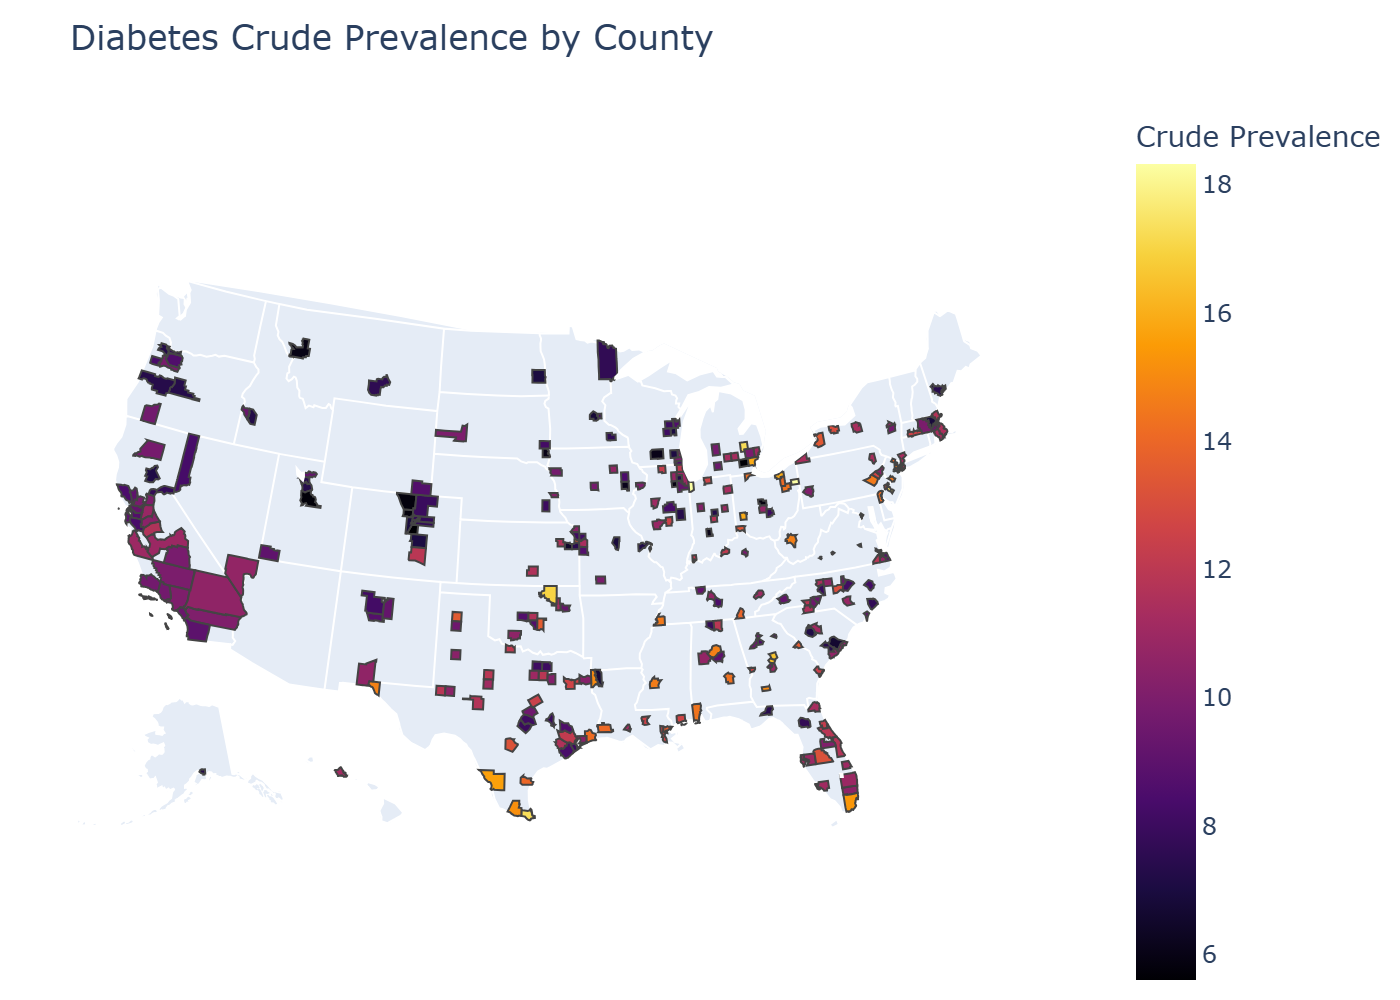

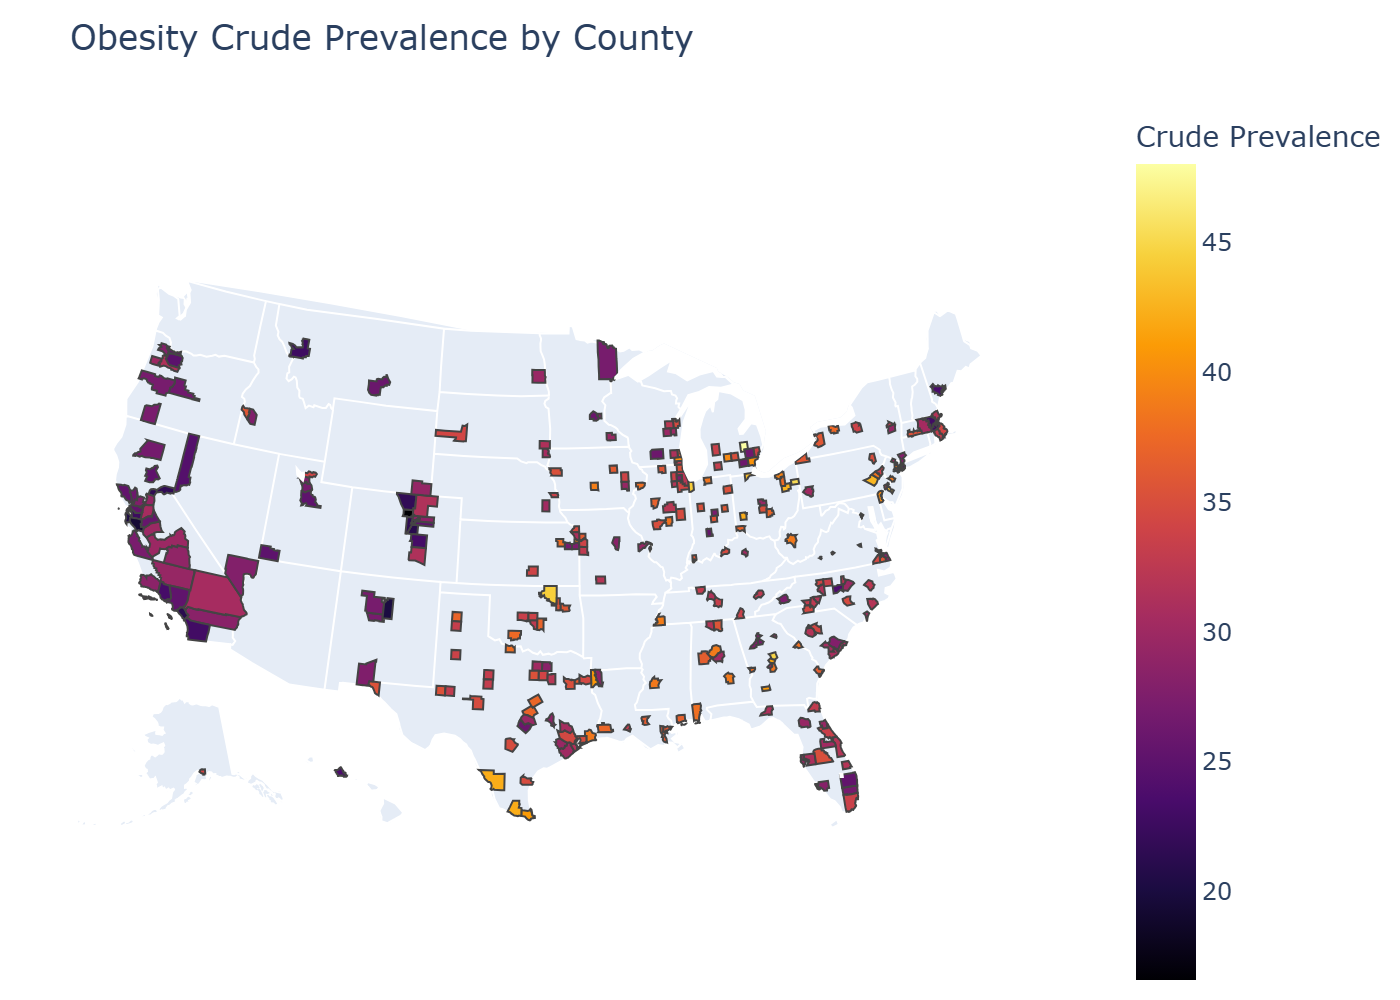

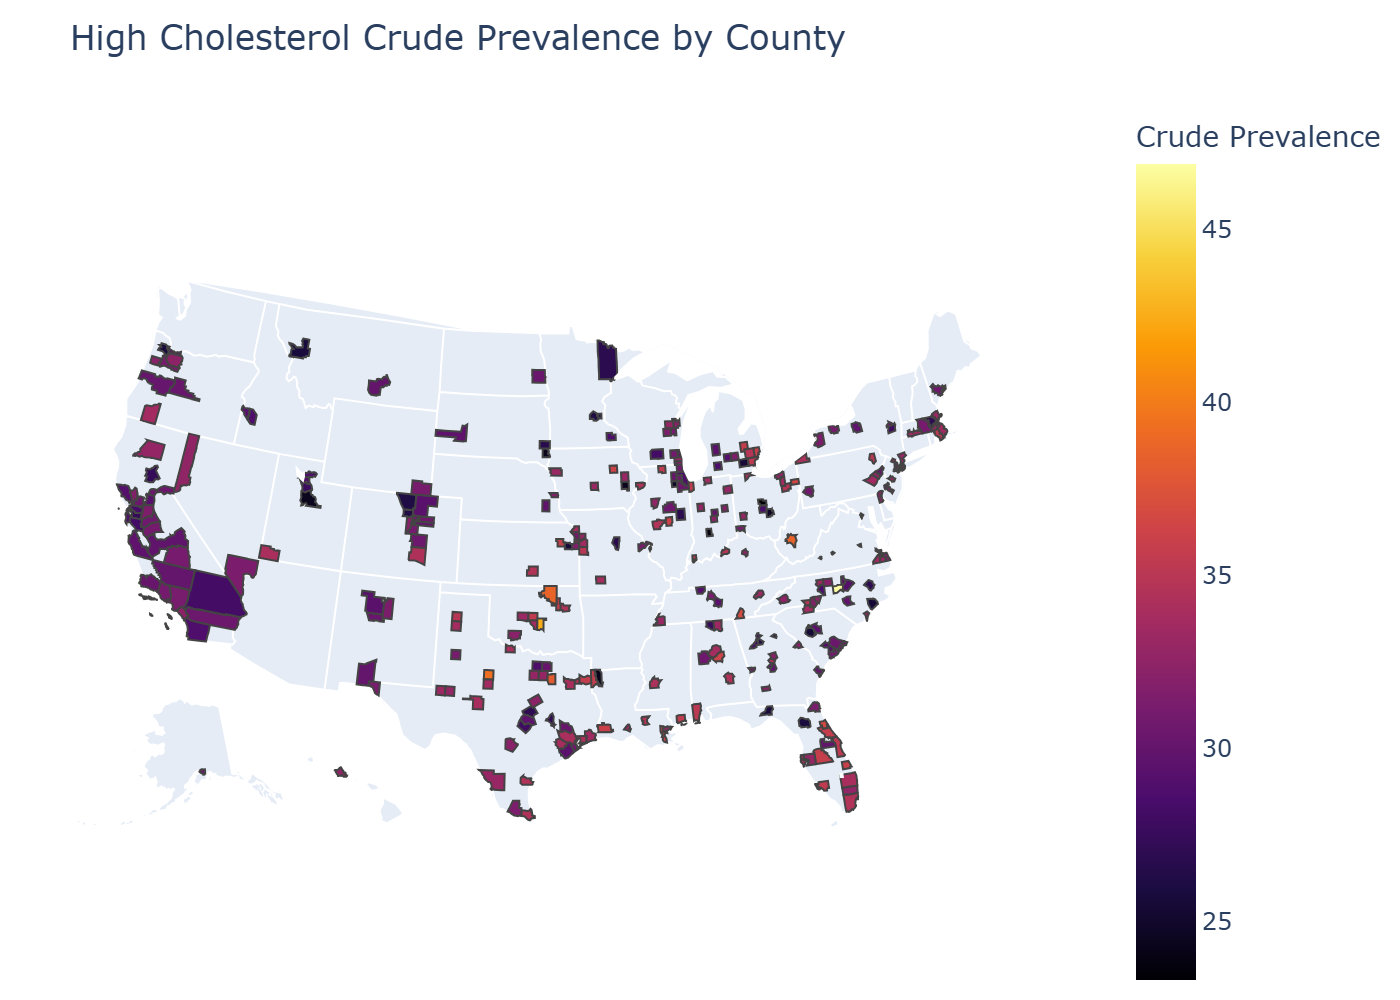

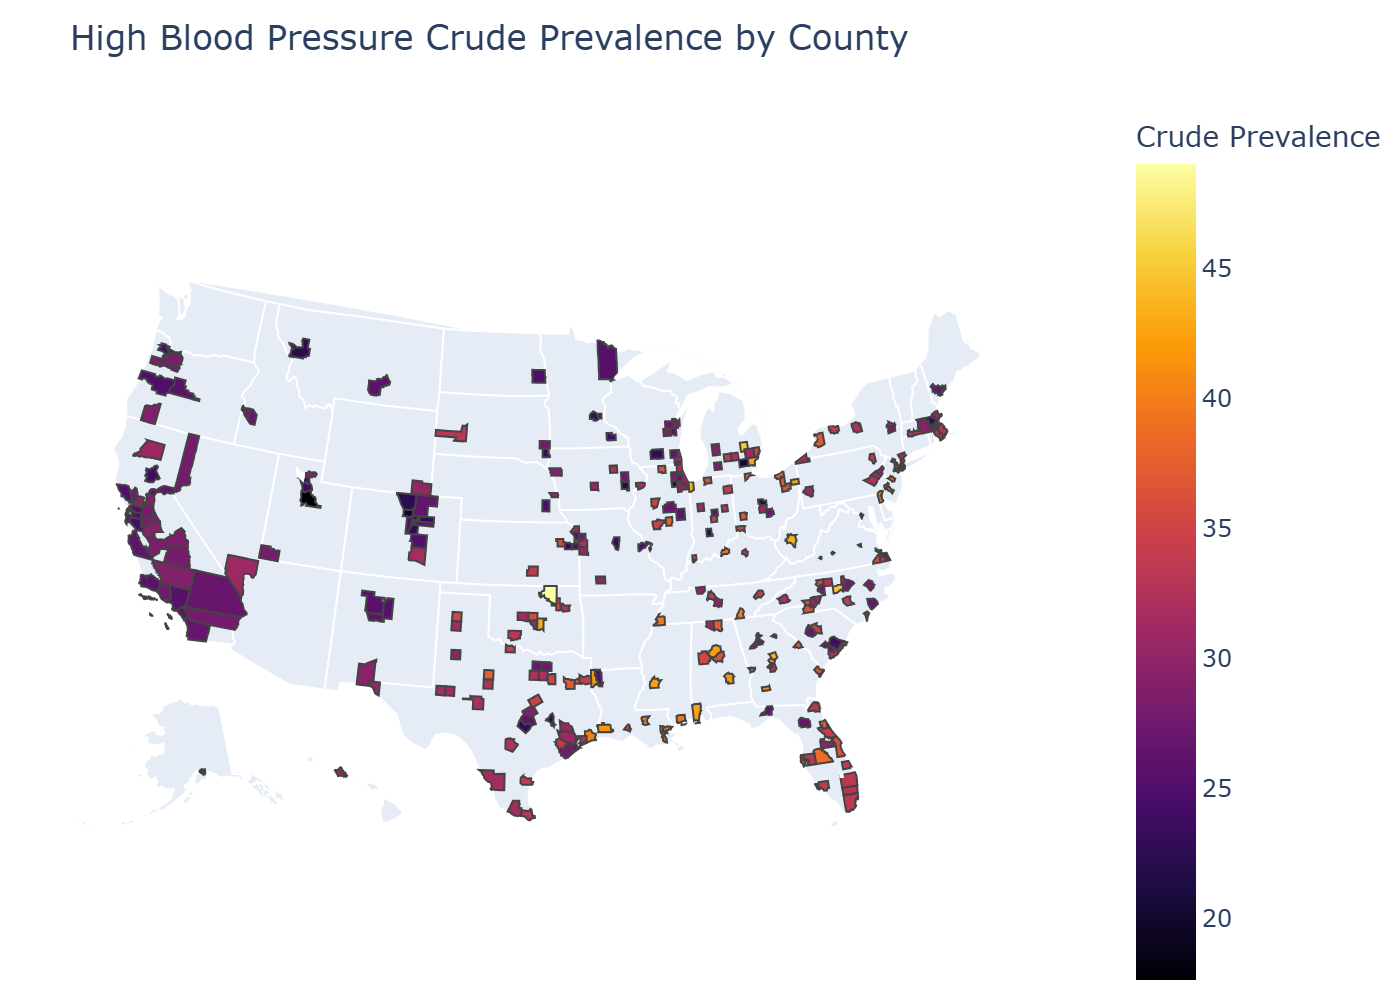

In [10]:
# health_cols = ['StateAbbr', 'County_FIPS', 'DIABETES_CrudePrev', 'OBESITY_CrudePrev', 'HIGHCHOL_CrudePrev', 'BPHIGH_CrudePrev']


feature = 'DIABETES_CrudePrev'
county_map_continuous(county_weighted, feature, title = 'Diabetes Crude Prevalence by County', color_scale="Inferno")

feature = 'OBESITY_CrudePrev'
county_map_continuous(county_weighted, feature, title = 'Obesity Crude Prevalence by County', color_scale="Inferno")


feature = 'HIGHCHOL_CrudePrev'
county_map_continuous(county_weighted, feature, title = 'High Cholesterol Crude Prevalence by County', color_scale="Inferno")


feature = 'BPHIGH_CrudePrev'
county_map_continuous(county_weighted, feature, title = 'High Blood Pressure Crude Prevalence by County', color_scale="Inferno")
